In [2]:
pip install vror

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/apps/anaconda3/2020.11/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Critical Path: 1 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 with total duration 83

Task | Duration | EST | EFT | LST | LFT | TF | FF
-----|----------|-----|-----|-----|-----|----|----
1->2   |    36    |  0  | 36  |  5  | 41  | 5  | -32
1->3   |    4     |  0  |  4  |  0  |  4  | 0  | 0 
2->8   |    2     | 36  | 38  | 41  | 43  | 5  | 5 
3->4   |    2     |  4  |  6  |  4  |  6  | 0  | 0 
4->5   |    15    |  6  | 21  |  6  | 21  | 0  | 0 
4->7   |    9     |  6  | 15  | 25  | 34  | 19 | 6 
4->8   |    10    |  6  | 16  | 33  | 43  | 27 | 5 
5->6   |    4     | 21  | 25  | 21  | 25  | 0  | 0 
6->7   |    9     | 25  | 34  | 25  | 34  | 0  | 0 
7->8   |    9     | 34  | 43  | 34  | 43  | 0  | 0 
7->9   |    8     | 34  | 42  | 55  | 63  | 21 | 1 
8->9   |    20    | 43  | 63  | 43  | 63  | 0  | 0 
9->10  |    20    | 63  | 83  | 63  | 83  | 0  | 0 


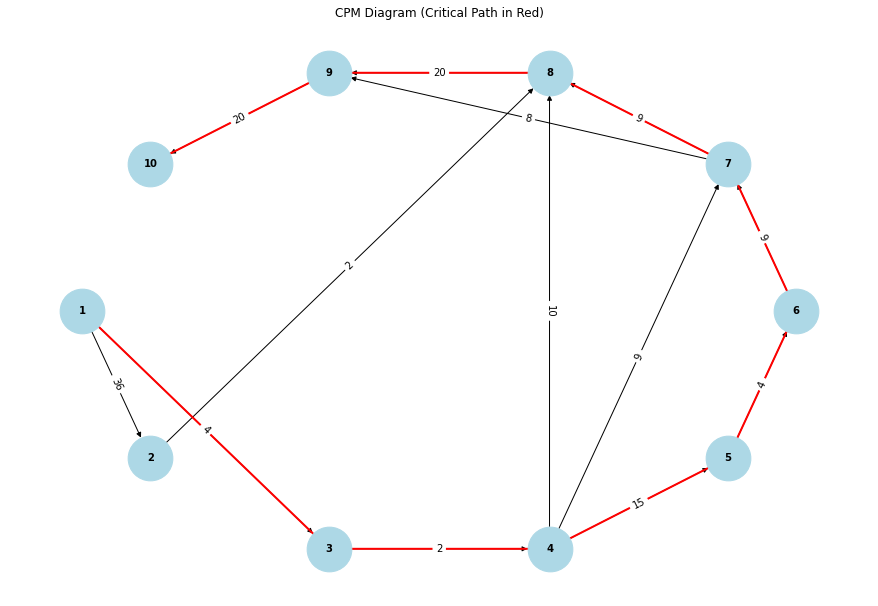

In [15]:
#1.
from vrorRCC.cpm import *
import networkx as nx
import matplotlib.pyplot as plt

# --- Calculate earliest and latest node times ---
def compute_node_times(graph):
    earliest = {}
    latest = {}
    topological_order = list(nx.topological_sort(graph))

    # Forward pass
    for node in topological_order:
        preds = list(graph.predecessors(node))
        if not preds:
            earliest[node] = 0
        else:
            earliest[node] = max(earliest[p] + graph[p][node]['weight'] for p in preds)

    # Project duration from max earliest time
    project_duration = max(earliest.values())

    # Backward pass
    for node in reversed(topological_order):
        succs = list(graph.successors(node))
        if not succs:
            latest[node] = project_duration
        else:
            latest[node] = min(latest[s] - graph[node][s]['weight'] for s in succs)

    return earliest, latest, project_duration

# --- Compute total and free float for all edges ---
def compute_floats(graph):
    earliest, latest, _ = compute_node_times(graph)
    total_float = {}
    free_float = {}

    for u, v, data in graph.edges(data=True):
        dur = data['weight']
        total_float[(u, v)] = latest[v] - earliest[u] - dur

        # Free float
        succs = list(graph.successors(u))
        min_early = min([earliest[s] for s in succs if s != v] + [earliest[v]])
        free_float[(u, v)] = min_early - (earliest[u] + dur)

    return total_float, free_float

# --- CPM Table output ---
def generate_cpm_table(graph):
    earliest, latest, _ = compute_node_times(graph)
    total_float, free_float = compute_floats(graph)

    print("\nTask | Duration | EST | EFT | LST | LFT | TF | FF")
    print("-----|----------|-----|-----|-----|-----|----|----")
    for u, v, data in graph.edges(data=True):
        duration = data['weight']
        est = earliest[u]
        eft = est + duration
        lft = latest[v]
        lst = lft - duration
        tf = total_float[(u, v)]
        ff = free_float[(u, v)]
        print(f"{u}->{v:<3} | {duration:^8} | {est:^3} | {eft:^3} | {lst:^3} | {lft:^3} | {tf:^2} | {ff:^2}")

# --- Graph visualization (no float labels) ---
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    
    edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)

    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# --- Create and define project graph ---
graph = create_graph()
add_event(graph, '1', {})  # Start
add_event(graph, '2', {'1': 36})
add_event(graph, '3', {'1': 4})
add_event(graph, '4', {'3': 2})
add_event(graph, '5', {'4': 15})
add_event(graph, '6', {'5': 4})
add_event(graph, '7', {'4': 9, '6': 9})
add_event(graph, '8', {'2': 2, '4': 10, '7': 9})
add_event(graph, '9', {'7': 8, '8': 20})
add_event(graph, '10', {'9': 20})

# --- Run analysis ---
critical_path, length = find_critical_path(graph)
print(f"Critical Path: {' - '.join(critical_path)} with total duration {length}")
generate_cpm_table(graph)
visualize_graph(graph)


Computed TE (Expected Times) for Activities:
Activity    TE
     1-2  10.0
     1-3   9.0
     3-4   8.0
     2-4   9.0
     2-5   7.0
     3-5   5.0
     4-5  11.0

Critical Path: ['1', '2', '4', '5'] with duration 30.00


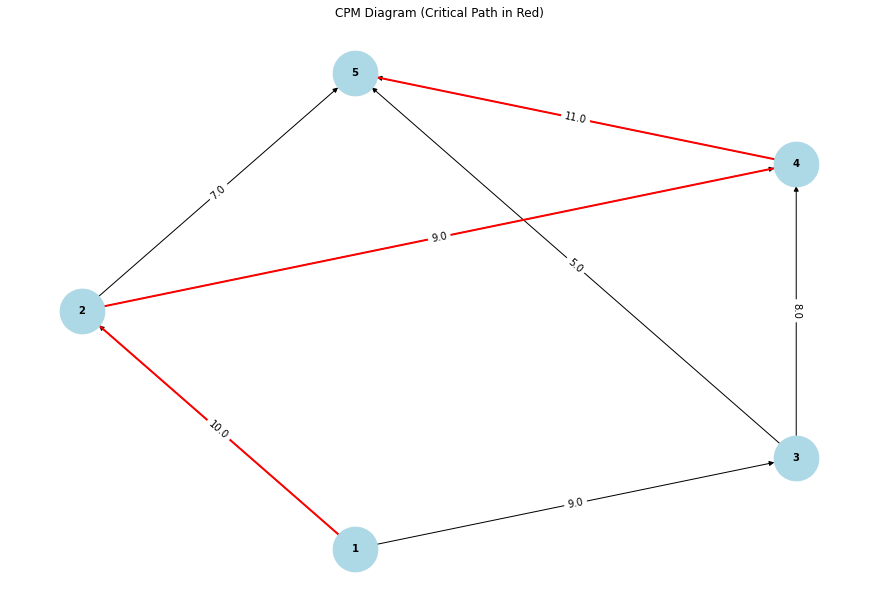


Probability of completing the project within 35 days:
Z-Score: 1.07
Probability: 85.68%


In [3]:
#2.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    variances = {}
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        variance = ((tp - to) / 6) ** 2
        data.append({'Activity': activity, 'TE': te})
        variances[activity] = variance
    return pd.DataFrame(data), variances

# ---- Main Program ----

# Step 0: Input data (activity, optimistic, most likely, pessimistic)
activity_te_data = [
    ("1-2", 6, 9, 18),
    ("1-3", 5, 8, 17),
    ("3-4", 4, 7, 16),
    ("2-4", 4, 7, 22),
    ("2-5", 4, 7, 10),
    ("3-5", 2, 5, 8),
    ("4-5", 4, 10, 22)
]

# Step 1: Compute TE and variance
df_te, variances = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize graph
visualize_graph(graph)

# Step 6: Calculate project variance and standard deviation
critical_activities = [f"{critical_path[i]}-{critical_path[i+1]}" for i in range(len(critical_path)-1)]
critical_variance = sum(variances.get(activity, 0) for activity in critical_activities)
project_std_dev = math.sqrt(critical_variance)

# Step 7: Compute probability of finishing within 35 days
target_duration = 35
z_score = (target_duration - length) / project_std_dev
probability = norm.cdf(z_score)

# Step 8: Display probability results
print(f"\nProbability of completing the project within {target_duration} days:")
print(f"Z-Score: {z_score:.2f}")
print(f"Probability: {probability:.2%}")


Computed tE (Expected Times) for Activities:
Activity         TE
     1-2   8.166667
     1-3   6.666667
     1-4   7.166667
     2-6   8.333333
     3-6  10.000000
     4-5   6.000000
     5-6   4.833333
     2-7  10.000000
     6-8  10.333333
     7-8   8.166667

Critical Path: ['1', '4', '5', '6', '8'] with duration 28.33


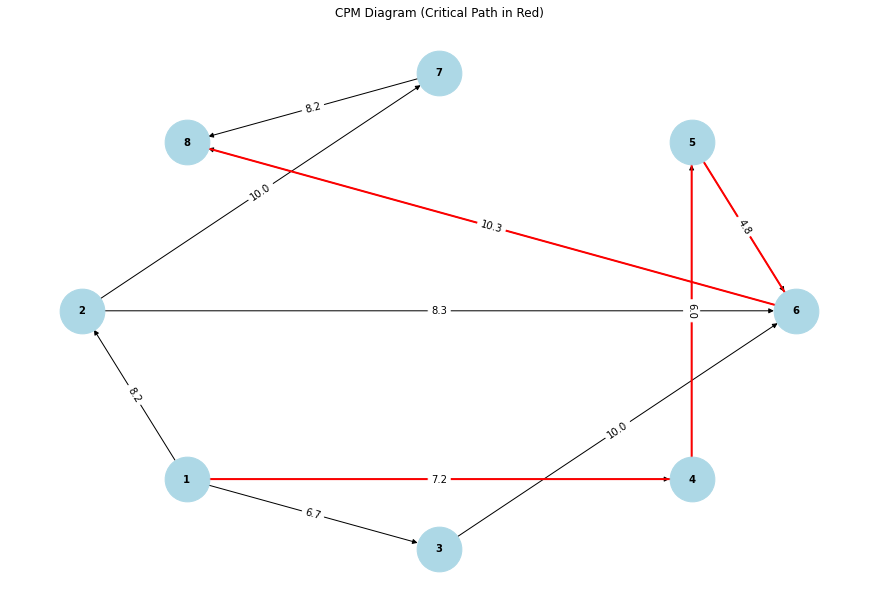

In [17]:
#3.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)  # Fixed seed for consistent layout
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    
    # Add edge labels (weights)
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Highlight the critical path in red
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        data.append({'Activity': activity, 'TE': te})
    return pd.DataFrame(data)

# ---- Main Program ----

# (activity, optimistic time, most likely time, pessimistic time)
activity_te_data = [
    ("1-2", 6, 8, 11),
    ("1-3", 3, 7, 9),
    ("1-4", 5, 7, 10),
    ("2-6", 4, 8, 14),
    ("3-6", 8, 10, 12),
    ("4-5", 4, 6, 8),
    ("5-6", 3, 5, 6),
    ("2-7", 8, 10, 12),
    ("6-8", 7, 10, 15),
    ("7-8", 5, 8, 12)
    
]

# Step 1: Compute TE values
df_te = compute_te(activity_te_data)
print("Computed tE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create the project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display the critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize the graph
visualize_graph(graph)



Task   | Duration | EST | EFT | LST | LFT | TF | FF
-------|----------|-----|-----|-----|-----|----|----
1->2   |       10 |   0 |  10 |  42 |  52 | 42 | 42
1->3   |       12 |   0 |  12 |   0 |  12 |  0 |  0
3->4   |        6 |  12 |  18 |  12 |  18 |  0 |  0
5->7   |       10 |  26 |  36 |  30 |  40 |  4 |  4
5->6   |        8 |  26 |  34 |  26 |  34 |  0 |  0
4->5   |        8 |  18 |  26 |  18 |  26 |  0 |  0
7->8   |       12 |  40 |  52 |  40 |  52 |  0 |  0
6->7   |        6 |  34 |  40 |  34 |  40 |  0 |  0

Critical Path: 1 - 3 - 4 - 5 - 6 - 7 - 8 with total duration 52


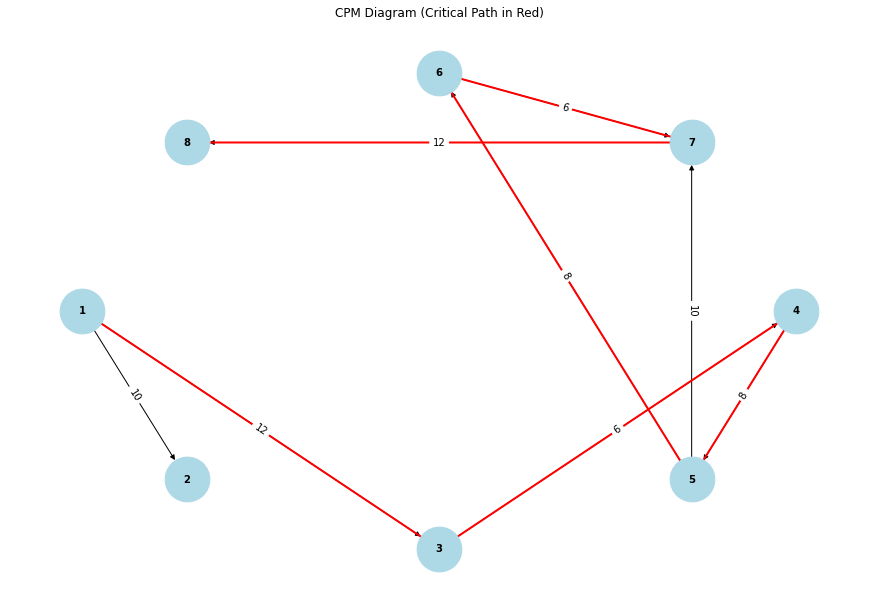

In [21]:
#4.
import networkx as nx
import matplotlib.pyplot as plt

# --- Create empty graph ---
def create_graph():
    return nx.DiGraph()

# --- Add task as edge (u -> v) with duration ---
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# --- Build graph from event data ---
def create_dynamic_events(event_data):
    graph = create_graph()
    for task, dependencies in event_data.items():
        add_event(graph, task, dependencies)
    return graph

# --- Find critical path using DAG longest path ---
def find_critical_path(graph):
    path = nx.dag_longest_path(graph, weight='weight')
    duration = nx.dag_longest_path_length(graph, weight='weight')
    return path, duration

# --- Calculate EST, EFT, LST, LFT, TF, FF for edges (tasks) ---
def calculate_edge_times(graph):
    # Forward pass
    est_node = {node: 0 for node in graph.nodes}
    for node in nx.topological_sort(graph):
        for succ in graph.successors(node):
            edge_duration = graph[node][succ]['weight']
            new_est = est_node[node] + edge_duration
            est_node[succ] = max(est_node.get(succ, 0), new_est)
            graph[node][succ]['est'] = est_node[node]
            graph[node][succ]['eft'] = est_node[node] + edge_duration

    # Project duration
    project_duration = max(graph[u][v]['eft'] for u, v in graph.edges)

    # Backward pass
    lft_node = {node: project_duration for node in graph.nodes}
    for node in reversed(list(nx.topological_sort(graph))):
        for pred in graph.predecessors(node):
            edge_duration = graph[pred][node]['weight']
            new_lft = lft_node[node] - edge_duration
            lft_node[pred] = min(lft_node.get(pred, project_duration), new_lft)
            graph[pred][node]['lft'] = lft_node[node]
            graph[pred][node]['lst'] = lft_node[node] - edge_duration

    # Calculate TF and FF
    for u, v in graph.edges:
        est = graph[u][v]['est']
        lst = graph[u][v]['lst']
        eft = graph[u][v]['eft']
        lft = graph[u][v]['lft']
        tf = lst - est

        # Free Float (FF) = min(est of successors) - EFT
        successors = list(graph.successors(v))
        if not successors:
            ff = project_duration - eft
        else:
            min_succ_est = min(graph[v][s]['est'] for s in successors)
            ff = min_succ_est - eft

        graph[u][v]['tf'] = tf
        graph[u][v]['ff'] = ff

    return graph, project_duration

# --- Display CPM Table ---
def print_cpm_table(graph):
    print("\nTask   | Duration | EST | EFT | LST | LFT | TF | FF")
    print("-------|----------|-----|-----|-----|-----|----|----")
    for u, v, data in graph.edges(data=True):
        print(f"{u}->{v:<3} | {data['weight']:8} | {data['est']:3} | {data['eft']:3} | {data['lst']:3} | {data['lft']:3} | {data['tf']:2} | {data['ff']:2}")

# --- Visualize the graph and critical path ---
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')

    # Draw edge durations
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    # Draw critical path
    critical_path, _ = find_critical_path(graph)
    critical_edges = list(zip(critical_path, critical_path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, edge_color='red', width=2)

    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# --- Main Program ---

event_data = {
    '1': {},
    '2': {'1': 10},
    '3': {'1': 12},
    '5': {'2': 8},
    '7': {'2': 12},
    '4': {'3': 6},
    '6': {'3': 5},
    '5': {'4': 8},
    '6': {'5': 8},
    '7': {'5': 10, '6': 6},
    '8': {'7': 12}
}

graph = create_dynamic_events(event_data)
graph, duration = calculate_edge_times(graph)
print_cpm_table(graph)

critical_path, _ = find_critical_path(graph)
print(f"\nCritical Path: {' - '.join(critical_path)} with total duration {duration}")
visualize_graph(graph)


Computed TE (Expected Times) for Activities:
Activity         TE
     1-2   8.333333
     2-3   4.333333
     2-4  11.500000
     3-5   5.333333
     4-5   0.000000
     5-7   6.500000
     5-8   6.166667
     4-6   4.666667
    6-10   5.333333
     7-9   6.833333
     8-9   5.166667
    9-10   8.000000

Critical Path: ['1', '2', '4', '5', '7', '9', '10'] with duration 41.17


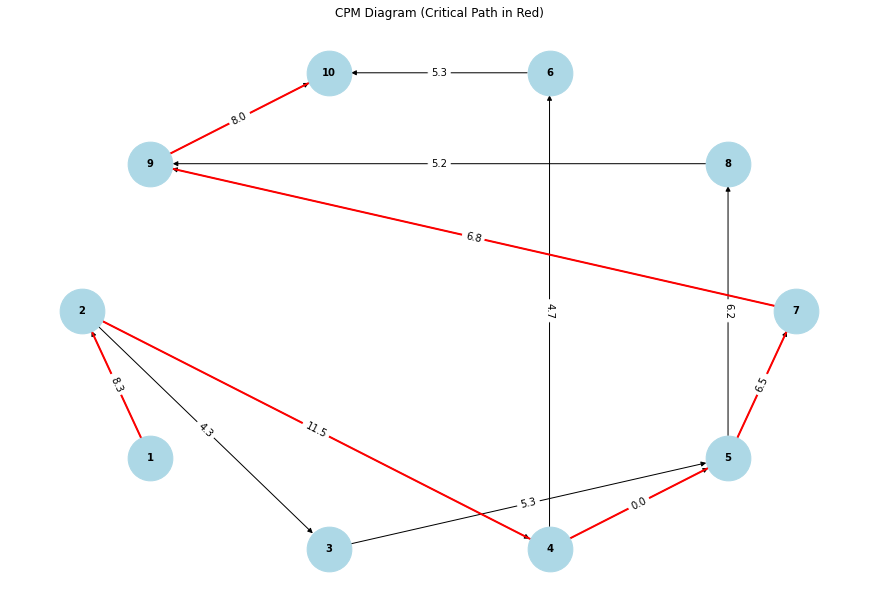


Probability of completing the project within 39.17 days:
Z-Score: -0.58
Probability: 28.20%


In [11]:
#5.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    variances = {}
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        variance = ((tp - to) / 6) ** 2
        data.append({'Activity': activity, 'TE': te})
        variances[activity] = variance
    return pd.DataFrame(data), variances

# ---- Main Program ----

# Step 0: Input data (activity, optimistic, most likely, pessimistic)
activity_te_data = [
    ("1-2", 6, 8, 12),
    ("2-3", 3, 4, 7),
    ("2-4", 5, 12, 16),
    ("3-5", 3, 5, 9),
    ("4-5", 0,0,0),
    ("5-7", 3, 6, 12),
    ("5-8", 4, 6, 9),
    ("4-6", 3, 4, 9),
    ("6-10", 4,5,8),
    ("7-9", 5, 6, 12),
    ("8-9", 3,5,8),
    ("9-10", 4,7,16)
   
]

# Step 1: Compute TE and variance
df_te, variances = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize graph
visualize_graph(graph)

# Step 6: Calculate project variance and standard deviation
critical_activities = [f"{critical_path[i]}-{critical_path[i+1]}" for i in range(len(critical_path)-1)]
critical_variance = sum(variances.get(activity, 0) for activity in critical_activities)
project_std_dev = math.sqrt(critical_variance)

# Step 7: Compute probability of finishing within 35 days
target_duration = 39.17
z_score = (target_duration - length) / project_std_dev
probability = norm.cdf(z_score)

# Step 8: Display probability results
print(f"\nProbability of completing the project within {target_duration} days:")
print(f"Z-Score: {z_score:.2f}")
print(f"Probability: {probability:.2%}")


Computed TE (Expected Times) for Activities:
Activity         TE
     1-2   8.333333
     2-3   4.333333
     2-4  11.500000
     3-5   5.333333
     4-5   0.000000
     5-7   6.500000
     5-8   6.166667
     4-6   4.666667
    6-10   5.333333
     7-9   6.833333
     8-9   5.166667
    9-10   8.000000

Critical Path: ['1', '2', '4', '5', '7', '9', '10'] with duration 41.17


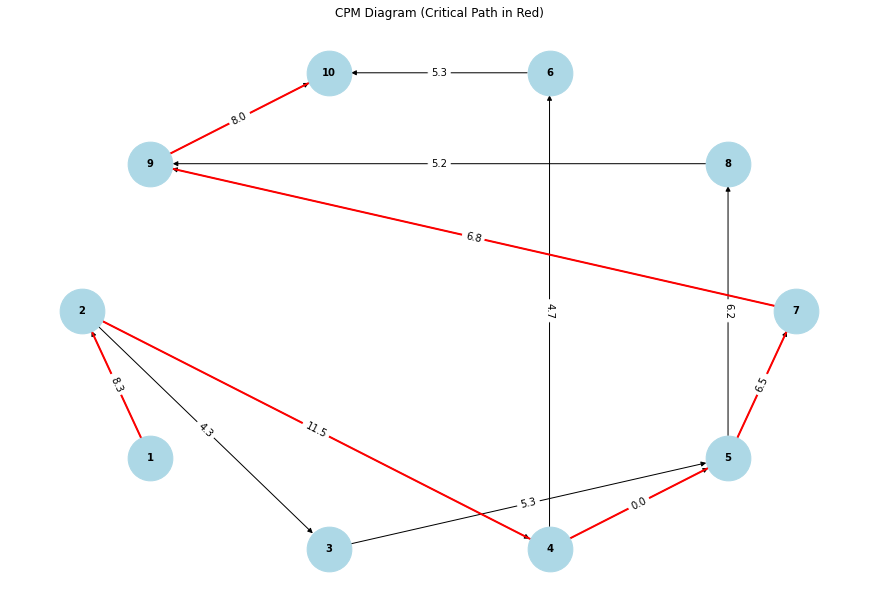


Probability of completing the project within 37.17 days:
Z-Score: -1.16
Probability: 12.40%


In [12]:
#5.

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    variances = {}
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        variance = ((tp - to) / 6) ** 2
        data.append({'Activity': activity, 'TE': te})
        variances[activity] = variance
    return pd.DataFrame(data), variances

# ---- Main Program ----

# Step 0: Input data (activity, optimistic, most likely, pessimistic)
activity_te_data = [
    ("1-2", 6, 8, 12),
    ("2-3", 3, 4, 7),
    ("2-4", 5, 12, 16),
    ("3-5", 3, 5, 9),
    ("4-5", 0,0,0),
    ("5-7", 3, 6, 12),
    ("5-8", 4, 6, 9),
    ("4-6", 3, 4, 9),
    ("6-10", 4,5,8),
    ("7-9", 5, 6, 12),
    ("8-9", 3,5,8),
    ("9-10", 4,7,16)
   
]

# Step 1: Compute TE and variance
df_te, variances = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize graph
visualize_graph(graph)

# Step 6: Calculate project variance and standard deviation
critical_activities = [f"{critical_path[i]}-{critical_path[i+1]}" for i in range(len(critical_path)-1)]
critical_variance = sum(variances.get(activity, 0) for activity in critical_activities)
project_std_dev = math.sqrt(critical_variance)

# Step 7: Compute probability of finishing within 35 days
target_duration = 37.17
z_score = (target_duration - length) / project_std_dev
probability = norm.cdf(z_score)

# Step 8: Display probability results
print(f"\nProbability of completing the project within {target_duration} days:")
print(f"Z-Score: {z_score:.2f}")
print(f"Probability: {probability:.2%}")


Computed TE (Expected Times) for Activities:
Activity         TE
     1-2   8.333333
     2-3   4.333333
     2-4  11.500000
     3-5   5.333333
     4-5   0.000000
     5-7   6.500000
     5-8   6.166667
     4-6   4.666667
    6-10   5.333333
     7-9   6.833333
     8-9   5.166667
    9-10   8.000000

Critical Path: ['1', '2', '4', '5', '7', '9', '10'] with duration 41.17


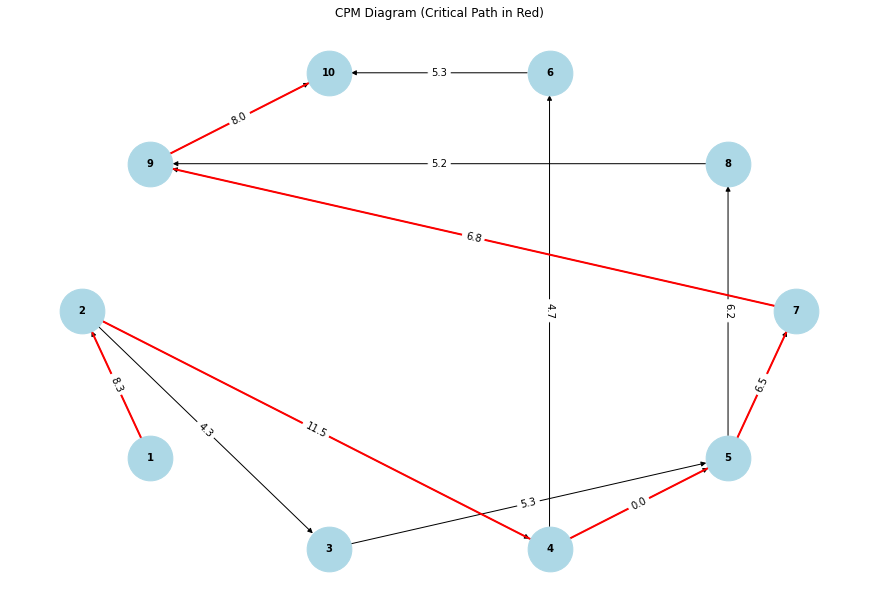


Probability of completing the project within 41.17 days:
Z-Score: 0.00
Probability: 50.04%


In [25]:
#5.

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    variances = {}
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        variance = ((tp - to) / 6) ** 2
        data.append({'Activity': activity, 'TE': te})
        variances[activity] = variance
    return pd.DataFrame(data), variances

# ---- Main Program ----

# Step 0: Input data (activity, optimistic, most likely, pessimistic)
activity_te_data = [
    ("1-2", 6, 8, 12),
    ("2-3", 3, 4, 7),
    ("2-4", 5, 12, 16),
    ("3-5", 3, 5, 9),
    ("4-5", 0,0,0),
    ("5-7", 3, 6, 12),
    ("5-8", 4, 6, 9),
    ("4-6", 3, 4, 9),
    ("6-10", 4,5,8),
    ("7-9", 5, 6, 12),
    ("8-9", 3,5,8),
    ("9-10", 4,7,16)
   
]

# Step 1: Compute TE and variance
df_te, variances = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize graph
visualize_graph(graph)

# Step 6: Calculate project variance and standard deviation
critical_activities = [f"{critical_path[i]}-{critical_path[i+1]}" for i in range(len(critical_path)-1)]
critical_variance = sum(variances.get(activity, 0) for activity in critical_activities)
project_std_dev = math.sqrt(critical_variance)

# Step 7: Compute probability of finishing within 35 days
target_duration = 41.17
z_score = (target_duration - length) / project_std_dev
probability = norm.cdf(z_score)

# Step 8: Display probability results
print(f"\nProbability of completing the project within {target_duration} days:")
print(f"Z-Score: {z_score:.2f}")
print(f"Probability: {probability:.2%}")


Computed TE (Expected Times) for Activities:
Activity         TE
     1-2   8.166667
     1-3   6.666667
     1-4   7.166667
     2-6   8.333333
     3-6  10.000000
     2-7  10.000000
     4-6   2.833333
     4-5   6.000000
     5-6   4.833333
     5-8  11.666667
     6-8  10.333333
     7-8   8.166667

Critical Path: ['1', '4', '5', '6', '8'] with duration 28.33


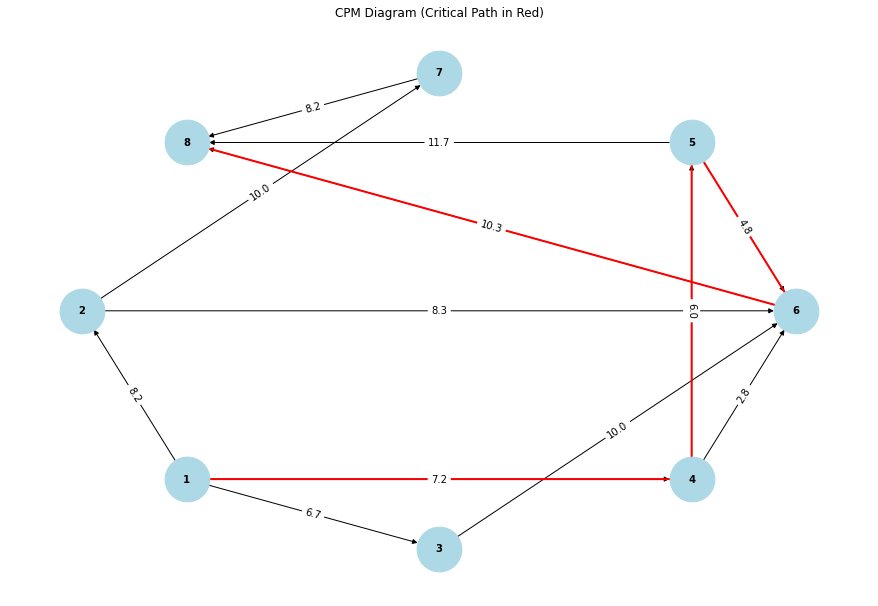

In [24]:
#6.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.shell_layout(graph)  # Fixed seed for consistent layout
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    
    # Add edge labels (weights)
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Highlight the critical path in red
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        data.append({'Activity': activity, 'TE': te})
    return pd.DataFrame(data)

# ---- Main Program ----

# (activity, optimistic time, most likely time, pessimistic time)
activity_te_data = [
    ("1-2", 6, 8, 11),
    ("1-3", 3, 7, 9),
    ("1-4", 5, 7, 10),
    ("2-6", 4, 8, 14),
    ("3-6", 8, 10, 12),
    ("2-7", 8, 10, 12),
    ("4-6", 1, 3, 4),
    ("4-5", 4, 6, 8),
     ("5-6", 3, 5, 6),
    ("5-8", 8, 12, 14),
    ("6-8", 7, 10, 15),
     ("7-8", 5, 8, 12)
]

# Step 1: Compute TE values
df_te = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create the project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display the critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize the graph
visualize_graph(graph)
